# Configure SBS Process Params

This notebook should be used as a test for ensuring correct SBS image loading and processing before running SBS processing.
Cells marked with `SET PARAMETERS` contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## SET PARAMETERS

### Fixed parameters for SBS processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [2]:
from pathlib import Path

import yaml
from tifffile import imread
import pandas as pd
from snakemake.io import expand
from microfilm.microplot import Microimage
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_micropanel,
    random_cmap,
    image_segmentation_annotations
)
from lib.shared.file_utils import get_filename
from lib.sbs_process.align_cycles import align_cycles
from lib.shared.log_filter import log_filter
from lib.sbs_process.compute_standard_deviation import compute_standard_deviation
from lib.sbs_process.max_filter import max_filter
from lib.sbs_process.find_peaks import find_peaks
from lib.shared.illumination_correction import apply_ic_field
from lib.shared.segment_cellpose import prepare_cellpose
from lib.shared.segment_cellpose import estimate_diameters
from lib.shared.segment_cellpose import segment_cellpose
from lib.sbs_process.extract_bases import extract_bases
from lib.sbs_process.call_reads import call_reads
from lib.sbs_process.call_cells import call_cells
from lib.shared.extract_phenotype_minimal import extract_phenotype_minimal
from lib.sbs_process.eval_mapping import (
    plot_mapping_vs_threshold,
    plot_cell_mapping_heatmap,
    plot_reads_per_cell_histogram,
    plot_gene_symbol_histogram,
)

## SET PARAMETERS

### Parameters for testing SBS processing

- `TEST_WELL`, `TEST_TILE`: Well/tile combination used for configuring parameters in this notebook.

### Channels

- `CHANNEL_NAMES`: A list of names for each channel in your SBS image. Should include one channel for DAPI and other channels for bases.
- `CHANNEL_CMAPS`: A list of color maps to use when showing channel microimages. These need to be a Matplotlib or microfilm colormap. We recommend using: `["pure_red", "pure_green", "pure_blue", "pure_cyan", "pure_magenta", "pure_yellow"]`.

In [3]:
# Define test well and tile
TEST_WELL = "A1"
TEST_TILE = 1
# Derive wildcard dictionary for testing
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

# Define image channels with DAPI as the first channel
CHANNEL_NAMES = ["DAPI", "G", "T", "A", "C"]
CHANNEL_CMAPS = ["pure_blue", "pure_green", "pure_red", "pure_cyan", "pure_magenta"]

# Remove DAPI channel to get bases
BASES = CHANNEL_NAMES[1:]

Loading test images...
Aligning test images...
Example aligned image for first cycle:


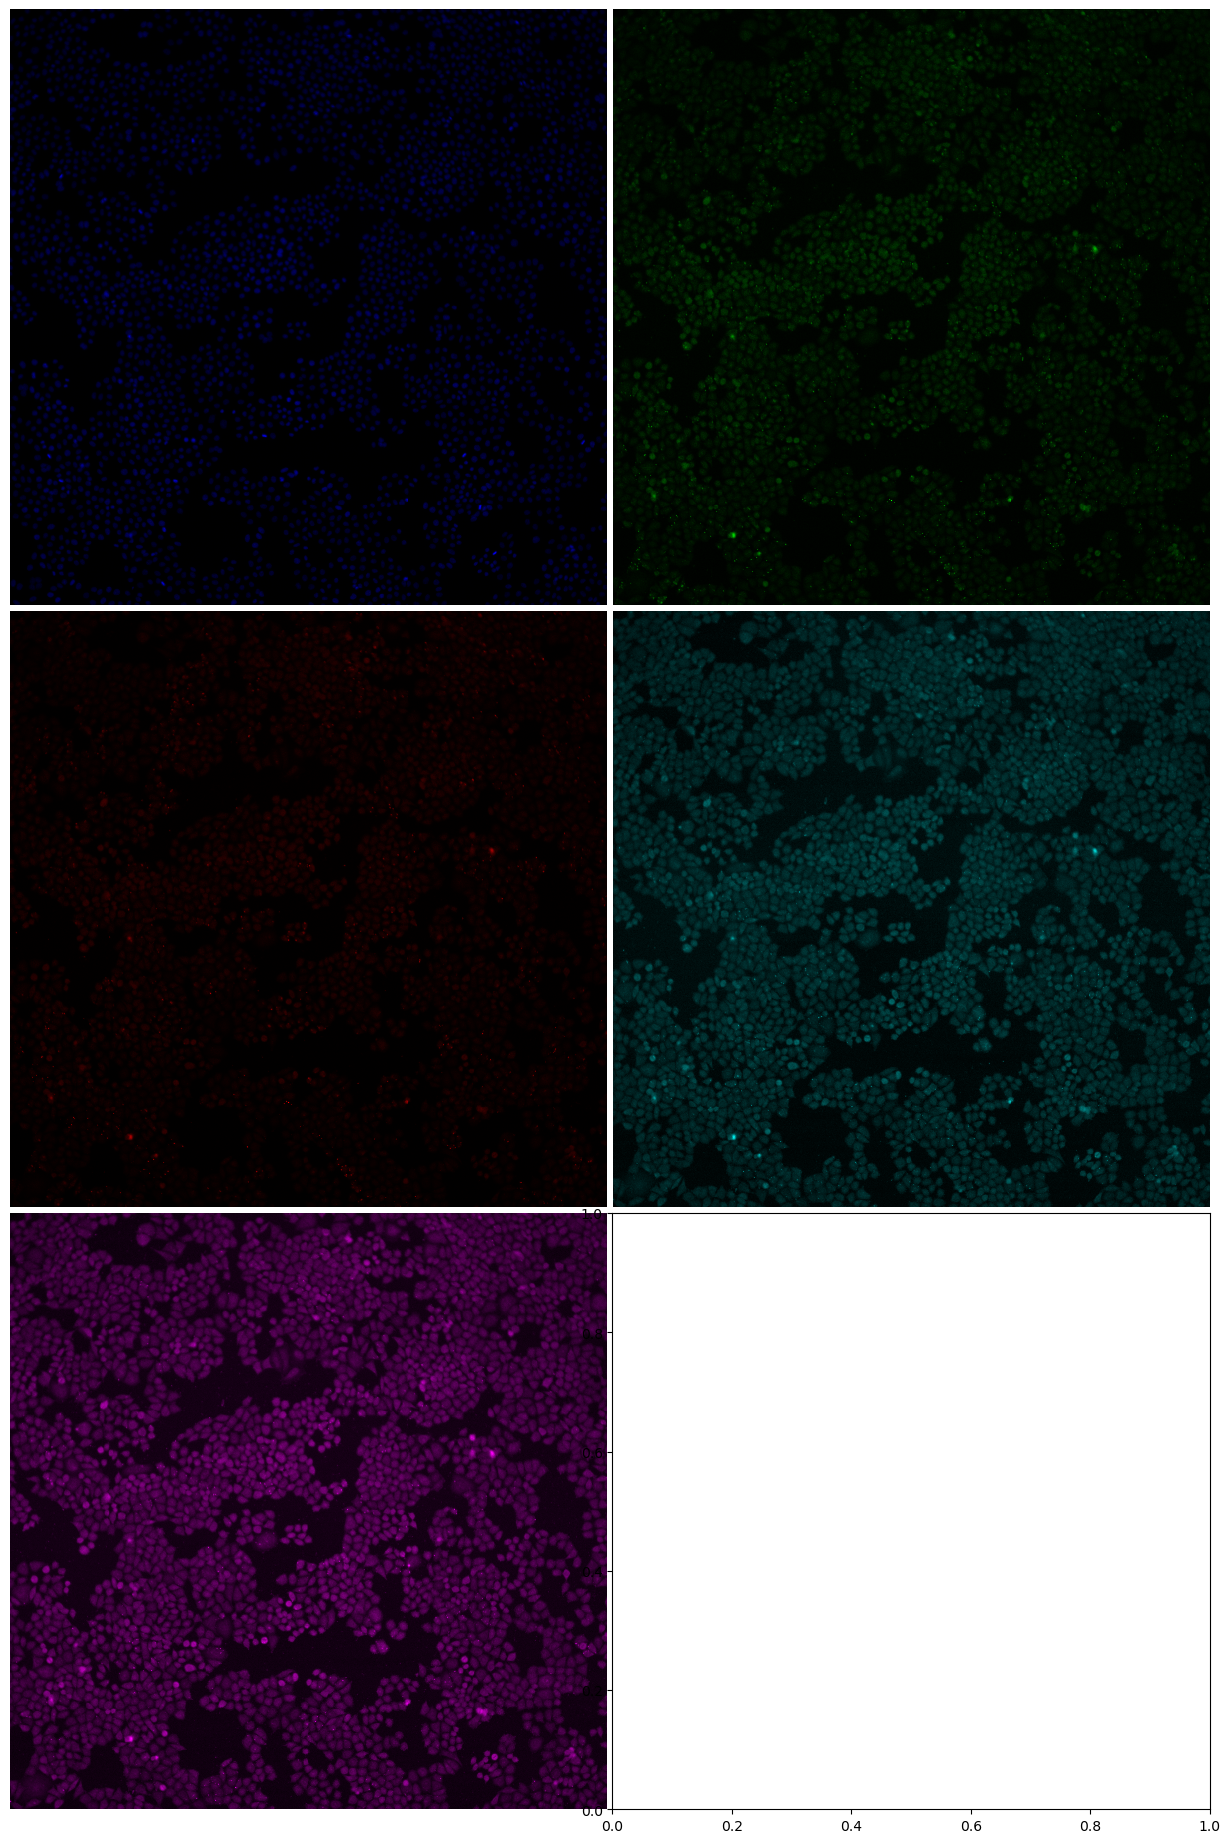

In [4]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# Get paths to the sample files dfs
SBS_SAMPLES_FP = Path(config["preprocess"]["sbs_samples_fp"])
# Load the sample TSV files with pandas
sbs_samples = pd.read_csv(SBS_SAMPLES_FP, sep="\t")
SBS_CYCLES = list(sbs_samples["cycle"].unique())

# load test image data
print("Loading test images...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
sbs_test_image_paths = expand(
    PREPROCESS_FP
    / "images"
    / "sbs"
    / get_filename(
        {"well": TEST_WELL, "tile": TEST_TILE, "cycle": "{cycle}"},
        "image",
        "tiff",
    ),
    cycle=SBS_CYCLES,
)
sbs_test_images = [imread(file_path) for file_path in sbs_test_image_paths]


# align cycles
print("Aligning test images...")
aligned = align_cycles(
    sbs_test_images,
    method="sbs_mean",
    upsample_factor=1,
)

# Create and display micropanel of aligned images
print("Example aligned image for first cycle:")
aligned_microimages = [
    Microimage(aligned[0, i, :, :], channel_names=CHANNEL_NAMES[i], cmaps=CHANNEL_CMAPS[i])
    for i in range(aligned.shape[1])
]
aligned_panel = create_micropanel(aligned_microimages, add_channel_label=True)
plt.show()

Detecting candidate reads...
Applying Laplacian-of-Gaussian (LoG) filter...
Computing standard deviation over cycles...
Applying max filter...
Finding peaks...
Example max filtered image for first cycle:


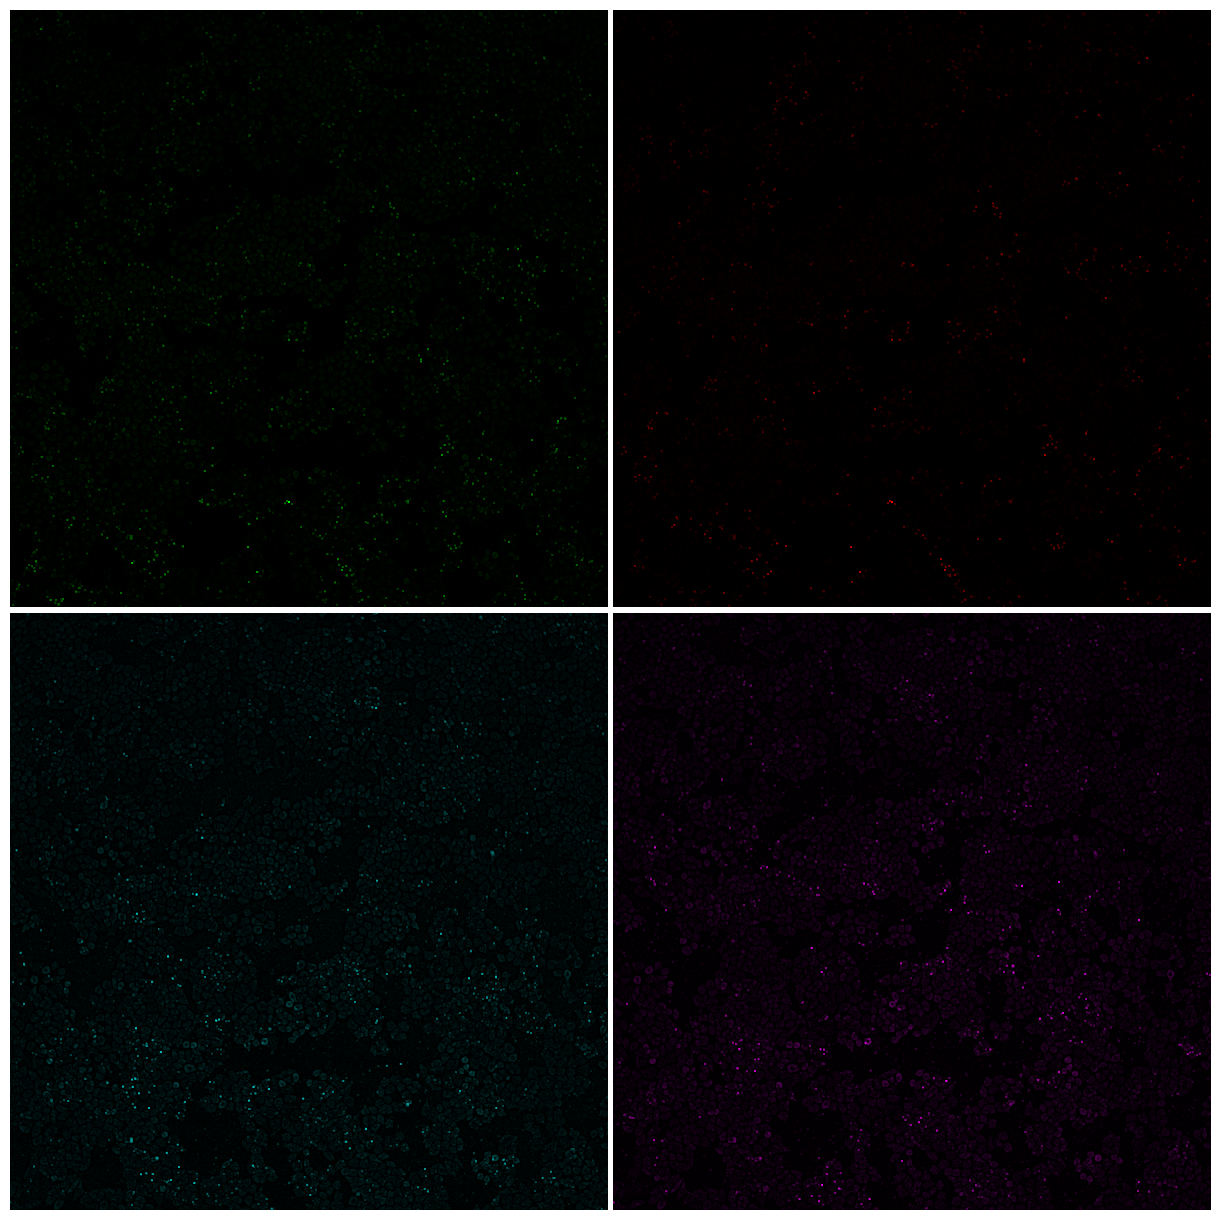

In [5]:
print("Detecting candidate reads...")

print("Applying Laplacian-of-Gaussian (LoG) filter...")
loged = log_filter(aligned, skip_index=0)

print("Computing standard deviation over cycles...")
standard_deviation = compute_standard_deviation(loged, remove_index=0)

print("Applying max filter...")
maxed = max_filter(loged, width=3, remove_index=0)

print("Finding peaks...")
peaks = find_peaks(standard_deviation)

# Create and display micropanel of max filtered datas
print("Example max filtered image for first cycle:")
maxed_microimages = [
    Microimage(maxed[0, i, :, :], channel_names=BASES[i], cmaps=CHANNEL_CMAPS[i+1]) for i in range(maxed.shape[1])
]
maxed_panel = create_micropanel(maxed_microimages, add_channel_label=True)
plt.show()

## SET PARAMETERS

### Illumination correction and Segmentation

- `SEGMENTATION_CYCLE_INDEX`: Index of cycle used for illumination correction and segmentation. Typically, this is set to the cycle with the brightest or clearest signal for cell boundaries, but in the case that we have just taken one multichannel image, it is set to that.
- `CYTO_CHANNEL`: The name of the cytoplasmic channel in your image stack. Typically the channel that best outlines cell boundaries, usually base C.

In [6]:
# Define cycle to use for segmentation, -1 for last cycle
SEGMENTATION_CYCLE_INDEX = -1
# Define cytoplasmic channel
CYTO_CHANNEL = "C"

# Derive DAPI and CYTO indexes
DAPI_INDEX = CHANNEL_NAMES.index("DAPI")
CYTO_INDEX = CHANNEL_NAMES.index(CYTO_CHANNEL)

Applying illumination correction to segmentation cycle image...
Preparing IC segmentation image for CellPose...
Pre-segmentation images:


/opt/homebrew/anaconda3/envs/brieflow_configuration/lib/python3.11/site-packages/skimage/util/dtype.py:576: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)


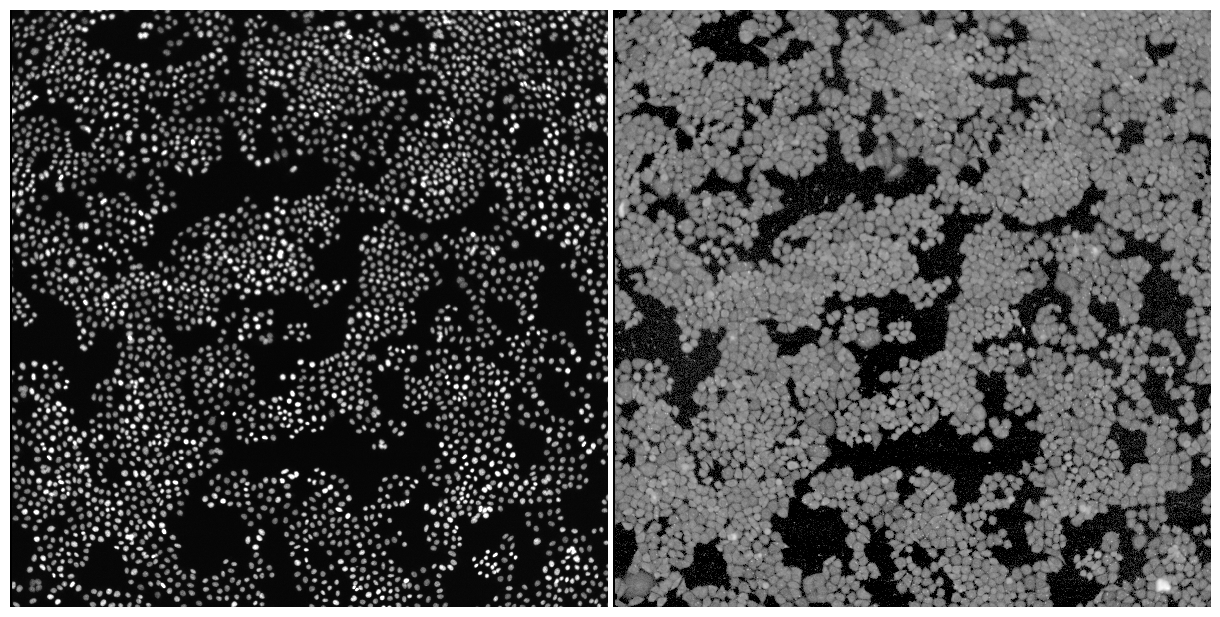

In [7]:
# Determine the cycle to use for segmentation
sbs_segmentation_cycle = SBS_CYCLES[SEGMENTATION_CYCLE_INDEX]
aligned_image_data_segmentation_cycle = aligned[SEGMENTATION_CYCLE_INDEX]

print("Applying illumination correction to segmentation cycle image...")
# Read the illumination correction file
ic_field_path = (
    PREPROCESS_FP
    / "ic_fields"
    / "sbs"
    / get_filename(
        {"well": TEST_WELL, "cycle": sbs_segmentation_cycle}, "ic_field", "tiff"
    )
)
ic_field = imread(ic_field_path)

# Apply illumination correction field
corrected_image_data = apply_ic_field(
    aligned_image_data_segmentation_cycle, correction=ic_field
)

# Prepare corrected image for CellPose segmentation
# NOTE: this process is done during the `segment_cellpose`` method below as well
# Use the prepared_cellpose image to test CellPose (see below)
print("Preparing IC segmentation image for CellPose...")
cellpose_rgb = prepare_cellpose(
    corrected_image_data,
    DAPI_INDEX,
    CYTO_INDEX,
)

# show max filtered data for one round
print("Pre-segmentation images:")
pre_seg_microimages = [
    Microimage(cellpose_rgb[2], channel_names="Dapi"),
    Microimage(cellpose_rgb[1], channel_names="Cyto"),
]
pre_seg_panel = create_micropanel(pre_seg_microimages, add_channel_label=True)
plt.show()

## SET PARAMETERS

### Illumination correction and segmentation

- `NUCLEI_DIAMETER`: Expected cell nuclei diameter. Used by CellPose during segmentation.
- `CELL_DIAMETER`: Expected cell cytoplasm diameter. Used by CellPose during segmentation.
- `CYTO_MODEL`: CellPose cyto model to use during segmentation.

Note: You may want to adjust the diameter parameters and segment to test if you feel like you are capturing too little or too much area for either of the two masks.

In [8]:
# Parameters for CellPose method
CYTO_MODEL = "cyto3"
FLOW_THRESHOLD = 0.4
CELLPROB_THRESHOLD = 0
GPU = False

In [ ]:
print("Estimating optimal cell and nuclei diameters...")
NUCLEI_DIAMETER, CELL_DIAMETER = estimate_diameters(
    corrected_image_data,
    dapi_index=DAPI_INDEX,
    cyto_index=CYTO_INDEX,
    cyto_model=CYTO_MODEL,
)

Estimating optimal cell and nuclei diameters...
Estimating nuclei diameters...


/opt/homebrew/anaconda3/envs/brieflow_configuration/lib/python3.11/site-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = tor

Estimated nuclear diameter: 9.2 pixels
Estimating cell diameters...


In [ ]:
print("Segmenting IC segmentation image with CellPose...")
nuclei, cells = segment_cellpose(
    corrected_image_data,
    dapi_index=DAPI_INDEX,
    cyto_index=CYTO_INDEX,
    nuclei_diameter=NUCLEI_DIAMETER,
    cell_diameter=CELL_DIAMETER,
    cellpose_kwargs=dict(
        flow_threshold=FLOW_THRESHOLD,
        cellprob_threshold=CELLPROB_THRESHOLD,
    ),
    cyto_model=CYTO_MODEL,
    gpu=GPU,
)

# Create and display micropanel of nuclei segmention
print("Example microplots for DAPI channel and nuclei segmentation:")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_seg_microimages = [
    Microimage(cellpose_rgb[2], channel_names="Dapi"),
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
]
nuclei_seg_panel = create_micropanel(nuclei_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of segmented cells
print("Example microplots for merged channels and cells segmentation:")
cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_seg_microimages = [
    Microimage(cellpose_rgb, channel_names="Merged"),
    Microimage(cells, cmaps=cells_cmap, channel_names="Cells"),
]
cells_seg_panel = create_micropanel(cells_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of annotated data
print("Example microplot for sequencing data annotated with segmenation:")
annotated_data = image_segmentation_annotations(cellpose_rgb[1:], nuclei, cells)
annotated_microimage = [
    Microimage(
        annotated_data,
        channel_names="Merged",
        cmaps=["pure_blue", "pure_red", "pure_green"],
    )
]
annotated_panel = create_micropanel(
    annotated_microimage, num_cols=1, figscaling=10, add_channel_label=False
)
plt.show()

## SET PARAMETERS

### Extract base intensity, call reads, assign to cells

- `DF_DESIGN_PATH`: The path to your guide RNA design file.
- `THRESHOLD_READS`: Initial threshold for detecting sequencing reads, set to 0 for preliminary analysis. This parameter will be optimized based on the mapping rate vs. peak threshold plot generated below. A higher threshold increases confidence in read calls but reduces the total number of detected reads.

In [ ]:
# Define parameters for extracting bases
DF_DESIGN_PATH = "config/pool10_design.tsv"
THRESHOLD_READS = 0

In [ ]:
# Read and format guide data
df_design = pd.read_csv(DF_DESIGN_PATH, sep="\t")
df_pool = df_design.query("dialout==[0,1]").drop_duplicates("sgRNA")
df_pool["prefix"] = df_pool.apply(lambda x: x.sgRNA[: x.prefix_length], axis=1)  # 13
barcodes = df_pool["prefix"]

# Run extract_bases and call_reads with the default threshold
df_bases = extract_bases(peaks, maxed, cells, THRESHOLD_READS, wildcards=WILDCARDS, bases=BASES)
df_reads = call_reads(df_bases, peaks_data=peaks)

The following plots will help determine the optimal `THRESHOLD_READS` value for your data:

In [ ]:
print("Mapping rate vs. peak threshold for determining optimal peak cutoff:")
plot_mapping_vs_threshold(df_reads, barcodes, "peak")
plt.show()

#### Left Plot (All Reads):
- Shows how the peak threshold affects all detected reads
- Blue line: Mapping rate (fraction of reads matching expected barcodes)
- Solid orange line: Total number of mapped spots (reads with valid barcodes)
- Dotted orange line: Number of unique cells with at least one mapped read

#### Right Plot (Cell-Associated Reads Only):
- Shows the same metrics but only for reads associated with cells

#### Setting Threshold Peaks:
Look for the point where the blue line (mapping rate) begins to plateau (~400)
- Consider the trade-off with number of mapped spots and cells
- A threshold around 300-500 typically provides a good balance:
  - Achieves ~75% mapping rate
  - Retains a reasonable number of mapped spots
  - Maintains coverage across cells

In [ ]:
THRESHOLD_READS = 400

In [ ]:
# Re-run extract_bases and call_reads with the new threshold
print("Extracted bases:")
df_bases = extract_bases(
    peaks, maxed, cells, THRESHOLD_READS, wildcards=WILDCARDS, bases=BASES
)
display(df_bases)

print("Base intensity across cycles:")
ax = sns.pointplot(x="cycle", y="intensity", hue="channel", data=df_bases)
plt.show()

print("Intensity for each base:")
ax = sns.boxplot(
    x="channel", y="intensity", hue="channel", data=df_bases, showfliers=False
)
plt.show()

print("Called reads:")
df_reads = call_reads(df_bases, peaks_data=peaks)
display(df_reads)

## SET PARAMETERS

### Read mapping

- `Q_MIN`: The minimum quality score for each base read. Calculated as 1 - [log2(2 + second) / log2(2 + first)]. Default is 0 and typically remains unchanged. While the Q_min plot above shows the relationship between Q_min and mapping rate, adjusting THRESHOLD_READS is the preferred method for quality control. Higher Q_min values are more stringent but can excessively filter valid reads.

The following plots will help determine the optimal `Q_MIN` value for your data:

In [ ]:
print("Mapping rate vs. Q_min for determining optimal sequence quality cutoff:")
plot_mapping_vs_threshold(df_reads, barcodes, "Q_min")
plt.show()

#### Left Plot (All Reads):
- Shows how Q_min threshold affects all detected reads
- Blue line: Mapping rate (fraction of reads matching expected barcodes)
- Solid red line: Total number of mapped spots (reads with valid barcodes)
- Dotted red line: Number of unique cells with at least one mapped read

#### Right Plot (Cell-Associated Reads Only):
- Shows the same metrics but only for reads associated with cells

#### Interpreting Q_min Results:
With our optimized peak threshold, these plots confirm that adjusting Q_min provides little benefit:
- The mapping rate (blue line) is already very high at Q_min = 0
- Increasing Q_min only marginally improves mapping rate 
- However, this comes at a significant cost:
  - Total mapped spots and mapped cells decreases substantially
- The small gain in mapping rate doesn't justify the large loss of data

In [ ]:
# Define parameters for read mapping
Q_MIN = 0

In [ ]:
print("Corrected cells:")
df_cells = call_cells(df_reads, df_pool=df_pool, q_min=Q_MIN)
display(df_cells)

print("Minimal phenotype features:")
df_sbs_info = extract_phenotype_minimal(
    phenotype_data=nuclei, nuclei_data=nuclei, wildcards=WILDCARDS
)
display(df_sbs_info)

print("Summary of the fraction of cells mapping to one barcode:")
one_barcode_mapping = plot_cell_mapping_heatmap(
    df_cells,
    df_sbs_info,
    barcodes,
    mapping_to="one",
    mapping_strategy="gene symbols",
    shape="6W_sbs",
    return_plot=False,
    return_summary=True,
)
display(one_barcode_mapping)

print("Summary of the fraction of cells mapping to any barcode:")
any_barcode_mapping = plot_cell_mapping_heatmap(
    df_cells,
    df_sbs_info,
    barcodes,
    mapping_to="any",
    mapping_strategy="gene symbols",
    shape="6W_sbs",
    return_plot=False,
    return_summary=True,
)
display(any_barcode_mapping)

print("Histogram of the number of reads per cell:")
outliers = plot_reads_per_cell_histogram(df_cells, x_cutoff=20)
plt.show()

print("Histogram of the number of counts of each unique gene symbols:")
outliers = plot_gene_symbol_histogram(df_cells, x_cutoff=30)
plt.show()

## Add sbs process parameters to config file

The `mode` parameter in the config file determines how Snakemake will execute parameter searches for segmentation optimization. Setting the `mode` to `segment_sbs_paramsearch` will systematically explore combinations of:

1. Size Parameters:
   - `nuclei_diameter`: Expected diameter of cell nuclei
   - `cell_diameter`: Expected diameter of cell cytoplasm
   
2. CellPose Parameters:
   - `flow_threshold`: Controls sensitivity of segmentation boundaries (default value 0.4)
     - Lower values: More aggressive segmentation, may over-segment
     - Higher values: More conservative, may miss cell boundaries
   - `cellprob_threshold`: Controls cell detection confidence (default value 0)
     - Lower values: Detects more potential cells, may include false positives
     - Higher values: More stringent detection, may miss weaker signals

The parameter search will:
1. Generate segmentations using different parameter combinations
2. Save results for each combination
3. Allow you to visually inspect results to choose optimal values
4. Help identify the best balance between over- and under-segmentation

Running these parameter searches is a time and resource intensive process and should only be done on a small subset of the tiles in the dataset.

In [ ]:
# Add sbs_process section
config["sbs_process"] = {
    "segmentation_cycle_index": SEGMENTATION_CYCLE_INDEX,
    "dapi_index": DAPI_INDEX,
    "cyto_index": CYTO_INDEX,
    "nuclei_diameter": NUCLEI_DIAMETER,
    "cell_diameter": CELL_DIAMETER,
    "flow_threshold": FLOW_THRESHOLD,
    "cellprob_threshold": CELLPROB_THRESHOLD,
    "cyto_model": CYTO_MODEL,
    "threshold_peaks": THRESHOLD_READS,
    "bases": BASES,
    "df_design_path": DF_DESIGN_PATH,
    "q_min": Q_MIN,
    "gpu": GPU,
    "mode": "segment_sbs_paramsearch",
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)